# **Aprendizaje supervisado: métodos de clasificación**
---

En esta  tarea practicará las habilidades adquiridas aplicando métodos de clasificación y regresión. En el primer ejercicio utilizaremos el *dataset* **digits** de dígitos escritos a mano usando las utilidades de carga de *Scikit-Learn*.


## **0. Dependencias**
---
Ejecute la siguiente celda para importar las librerías necesarias.

In [ ]:
# Importamos scikit-learn
import sklearn

In [ ]:
# Importar librerías generales
import numpy as np
import pandas as pd

# Ignoramos las advertencias o warnings.
import warnings
warnings.simplefilter(action='ignore')

In [ ]:
#TEST_CELL
# Configuramos el formato por defecto de la
# librería de visualización Matplotlib.
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_theme()

In [ ]:
#TEST_CELL
!pip install -U plotly
import plotly
import plotly.express as px

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 22.2 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.15.0
    Uninstalling plotly-5.15.0:
      Successfully uninstalled plotly-5.15.0


In [ ]:
#TEST_CELL
!python --version
print('NumPy', np.__version__)
print('Pandas', pd.__version__)
print('Matplotlib', mpl.__version__)
print('Plotly', plotly.__version__)
print('Scikit-Learn', sklearn.__version__)

Python 3.10.12
NumPy 1.25.2
Pandas 2.0.3
Matplotlib 3.7.1
Plotly 5.20.0
Scikit-Learn 1.2.2


Este material fue creado con las siguientes versiones:

* Python: 3.7.10
* NumPy: 1.19.5
* Pandas: 1.1.5
* Matplotlib: 3.2.2
* Plotly: 4.14.3
* Scikit-Learn: 0.22.2.post

## **1. Clasificación de dígitos escritos a mano**
---
Una de las aplicaciones principales del aprendizaje automático es el procesamiento de imágenes en tiempo real. Existen *datasets* como [**MNIST**](http://yann.lecun.com/exdb/mnist/) construidos manualmente con datos clasificados manualmente, preparados para la aplicación de modelos computacionales.

En esta ocasión utilizaremos el *dataset* **`digits`**, un conjunto de datos de "juguete" inspirado en la misma idea, que consiste en observaciones con imágenes de $8$ x $8$ pixeles de dígitos del $0$ al $9$ escritos a mano.

El objetivo de este ejercicio es entrenar un modelo de clasificación supervisado basado en el algoritmo de **árboles de decisión** en donde a partir de una imagen de $8$ x $8$, genere una predicción de un número entero entre $0$ y $9$.

Para cargar el conjunto de datos se utilizará la función **`load_digits`** del módulo **`sklearn.datasets`**.

In [ ]:
#TEST_CELL
from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y= True)

X_digits.shape, y_digits.shape

((1797, 64), (1797,))

In [ ]:
#TEST_CELL
pd.Series(y_digits).value_counts()

3    183
1    182
5    182
4    181
6    181
9    180
7    179
0    178
2    177
8    174
Name: count, dtype: int64

$X$ tiene $64$ características, que corresponden a los $8 \times 8$ pixeles de cada imagen. En este sentido, se considera una fila de la imagen después de la otra, con el píxel $9$ (índice $8$ del *dataset*) siendo el primer pixel de la segunda fila, y así sucesivamente construyendo un vector de una dimensión con la misma regla:

$$index(i, j) = i + 8j$$

Con $i$ siendo el número de la fila y $j$ el de la columna, empezando en $0$.

A continuación, se muestra como al transformar una observación a la forma de $8 \times 8$ (con el método **`reshape`** de *NumPy*) podemos visualizar cada imagen individualmente (usando el método **`imshow`** de *Matplotlib*).

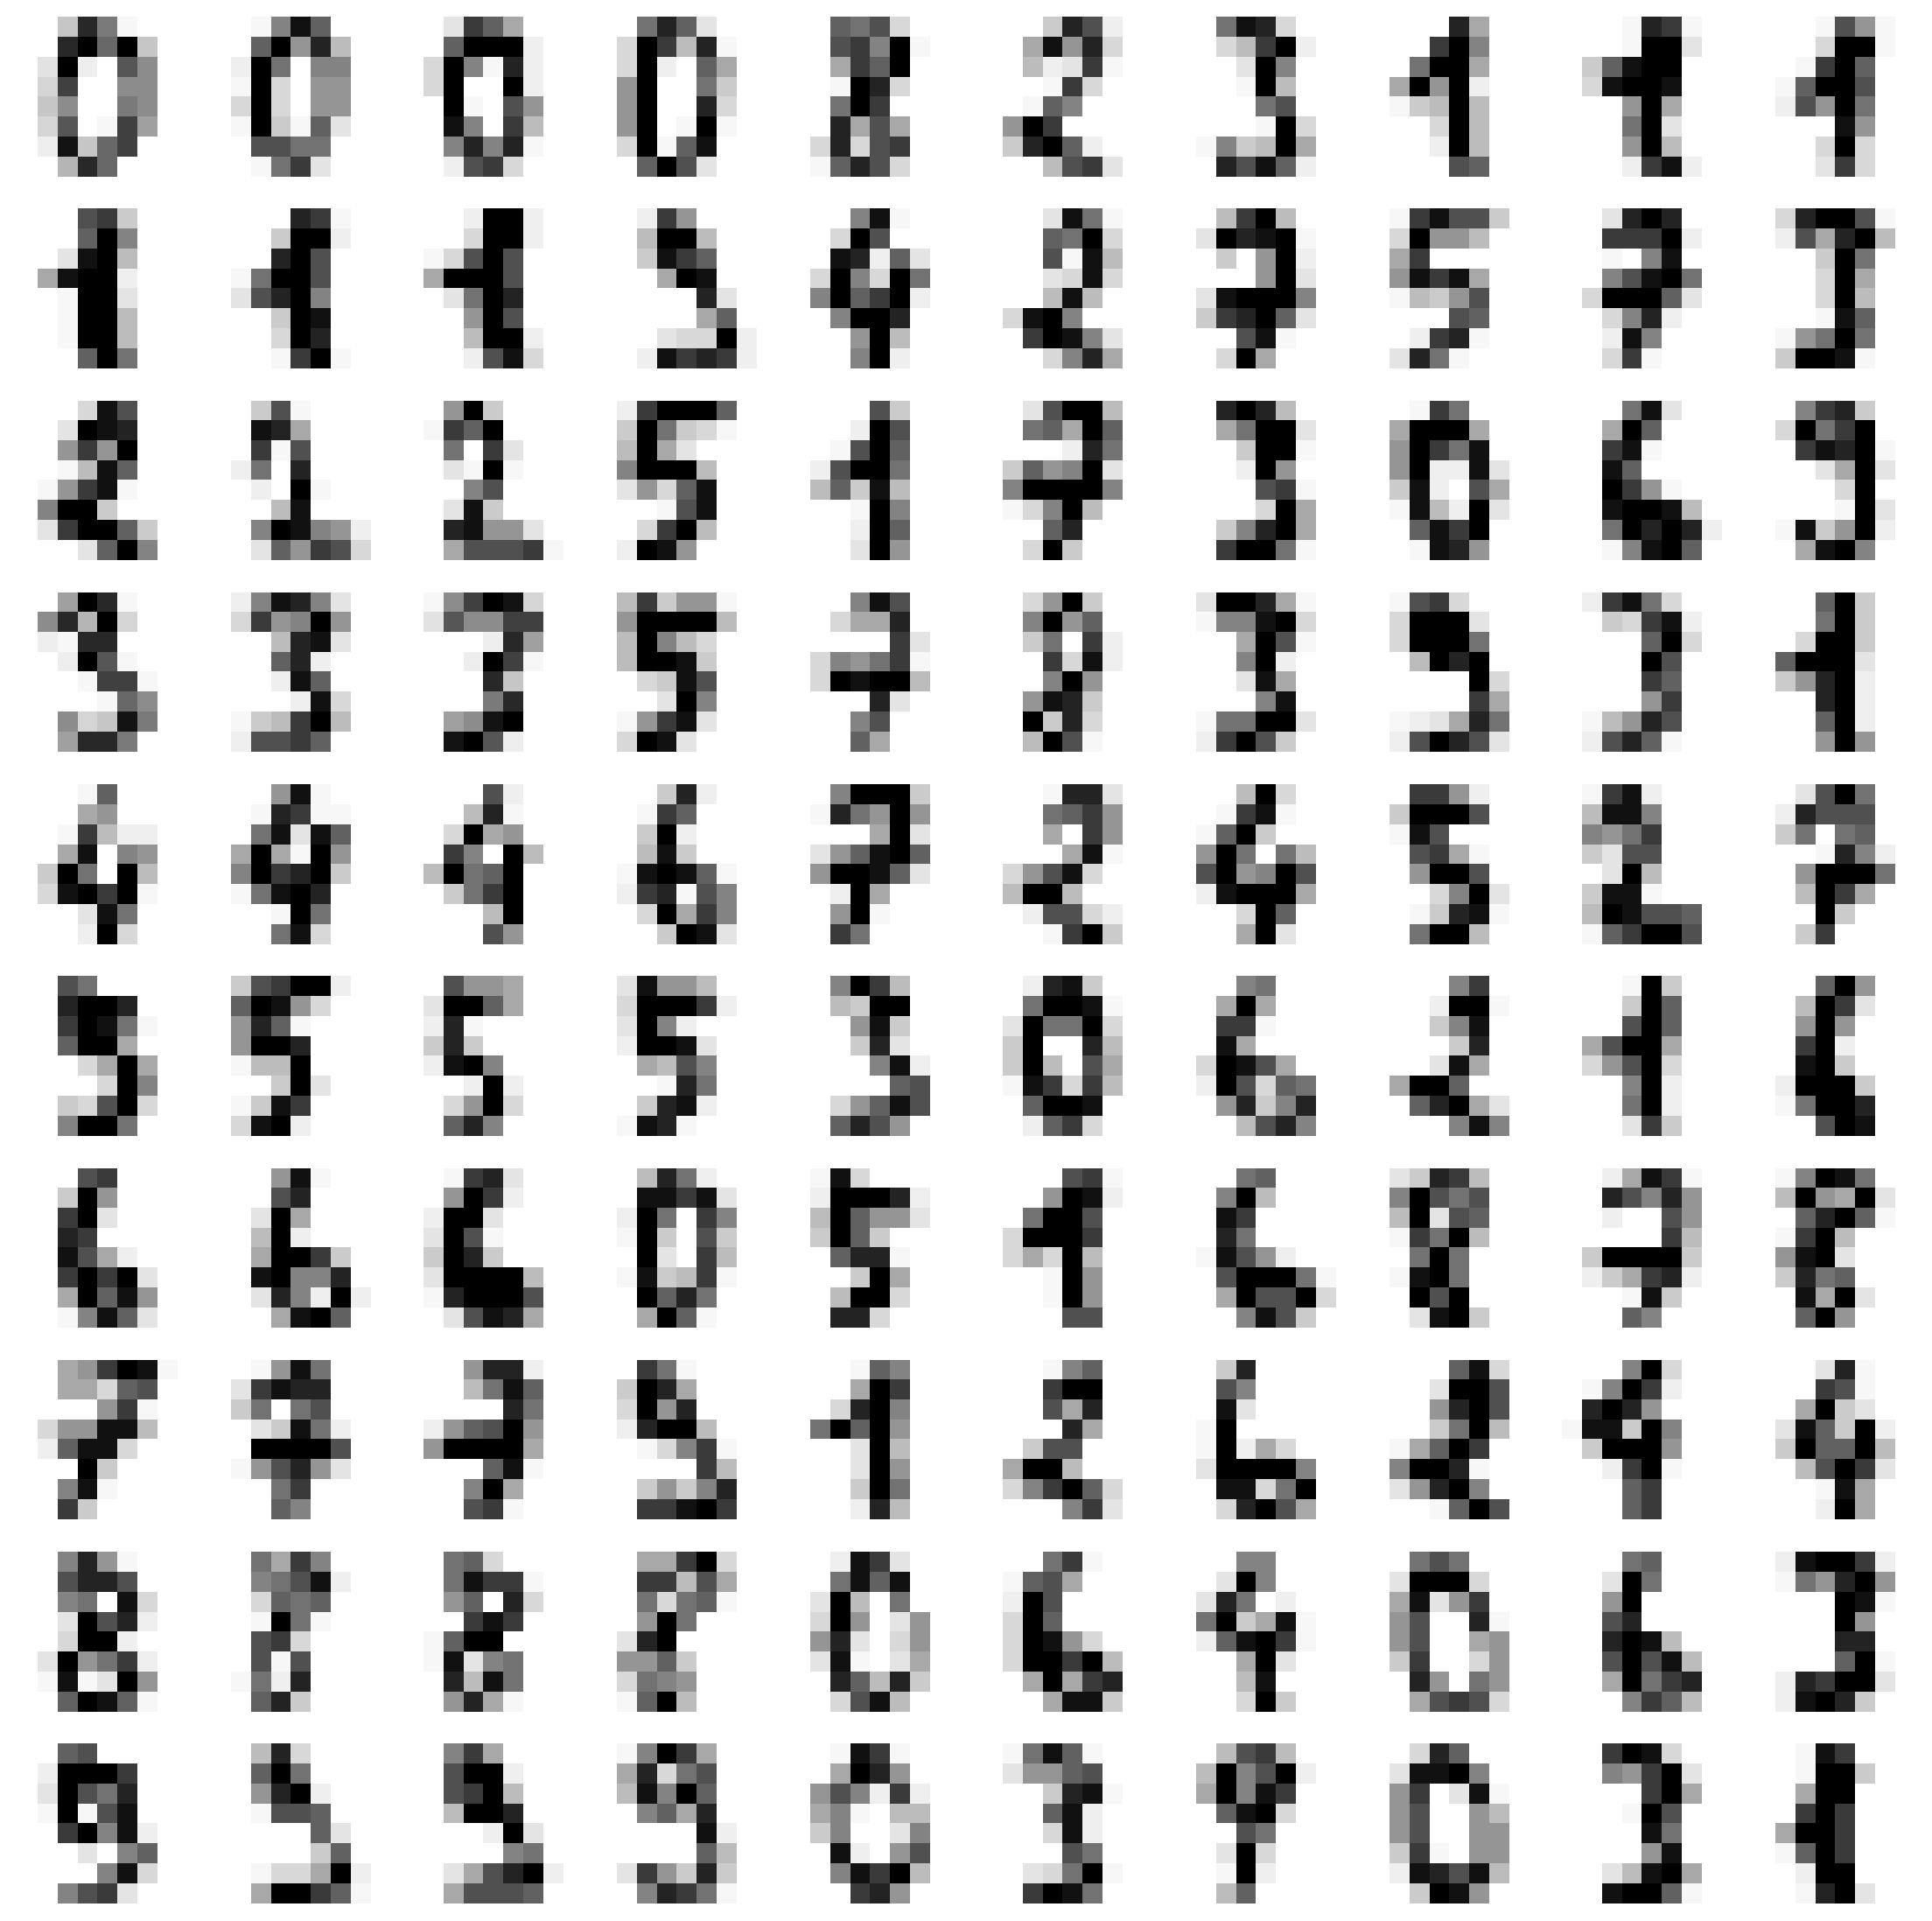

In [ ]:
#IGNORE_CELL
l = 10 # Número de imágenes por lado en la matriz de imágenes

fig, axes = plt.subplots(nrows = l, ncols = l, figsize = (14, 14))

for i in range(l):
  for j in range(l):
    ind =  np.random.randint(X_digits.shape[0]) # Seleccionamos el índice de una imagen al azar
    im = X_digits[i + j*l].reshape((8, 8)) # Retornamos la forma de la observación a dimensión 8x28
    axes[i, j].axis('off')
    axes[i, j].imshow(im, cmap = 'Greys')  # Mostramos en escala de grises cada pixel (enteros de 0 a 255).

A cada una de estas imágenes le corresponde una etiqueta (el número entero que representa) que se busca predecir en $y$. Utilice la siguiente función para visualizar la etiqueta e imagen de una observación dada.

In [ ]:
#TEST_CELL
#@title  { run: "auto" }
#@markdown Con el siguiente *slider* puede variar entre las observaciones una a visualizar. Puede cambiar este valor por un número entre 0 y 1796. Elija el índice del arreglo que desea revisar:
def digits_img(index, X, y):
  im = X[index].reshape((8,8))
  fig = px.imshow(im, title = f'<b>Etiqueta real: {y[index]}</b>', color_continuous_scale= 'dense',
                  labels=dict(x="Fila (i)", y="Columna (j)", color="Tono")
                  )
  fig.update_layout(
    font = {'size': 27},
    title={'x': 0.55, 'y': 0.915, 'xanchor': 'right'}
    )
  fig.show()

# Mostrar la observación n-ésima del dataset con su etiqueta correspondiente.
index = 1330 #@param {type:"slider", min:0, max:1796, step:1}

digits_img(index, X_digits, y_digits)

En este ejercicio usted deberá aplicar la metodología discutida en el curso para entrenar un modelo que prediga el número escrito en la imagen.

### **1.1. Particiones de entrenamiento y prueba de *digits***
---

Antes de continuar y como siempre, es importante definir primero los datos que serán usados para el entrenamiento y los que serán usados para evaluar el modelo.

En este punto deberá implementar la función **`load_digits_train_test`**, que a partir de un número real **`p`** genere una partición de los datos del *dataset* *digits* en datos de entrenamiento (**`X_digits_train`** y **`y_digits_train`**) y de evaluación (**`X_digits_test`** y **`y_digits_test`**), en donde el tamaño del conjunto de entrenamiento corresponda al porcentaje **`p`** del total de datos disponibles.

> **Nota:** La partición debe ser **estratificada** y debe aceptar el parámetro de semilla aleatoria **`seed`**. No se le dará como entrada el conjunto de datos y deberá cargarlo como se mencionó al principio de esta actividad.

**Entrada**:

* **`p`**: número real entre $0$ y $1$ con la proporción correspondiente a la partición de prueba.
* **`seed`**: número real con la semilla aleatoria para la generación de la partición.

**Salida**:
* **`X_train`**: arreglo de *NumPy* con *shape* aproximado $(n\cdot (1-p), m)$ para la partición de entrenamiento de **`X`**.
* **`X_test`**:  arreglo de *NumPy* con *shape* aproximado $(n\cdot p, m)$ para la partición de prueba de **`X`**.
* **`y_train`**: arreglo de *NumPy* con *shape* aproximado $(n \cdot (1-p),)$ para la partición de entrenamiento de **`y`**.
* **`y_test`**:  arreglo de *NumPy* con *shape* aproximado $(n\cdot p,)$ para la partición de prueba de **`y`**.





In [ ]:
# FUNCIÓN CALIFICADA load_digits_train_test:

# Módulo necesario para realizar el ejercicio.
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits

def load_digits_train_test(
  # ¡No modifique los valores por defecto de los argumentos!
              p = 0.3, seed = 333):
  """
  Entradas:
    p: proporción de los datos usado para prueba.
    seed: semilla aleatoria para la creación de la partición.
  Retorna:
    X_train: arreglo de NumPy con shape aproximado (n(1 - p), m)
              para la partición de entrenamiento de X.
    X_test:  arreglo de NumPy con shape aproximado (n(p), m)
              para la partición de prueba de X.
    y_train: arreglo de NumPy con shape aproximado (n(1 - p),)
              para la partición de entrenamiento de y.
    y_test:  arreglo de NumPy con shape aproximado (n(p),)
              para la partición de prueba de y.
  """
  ### ESCRIBA SU CÓDIGO AQUÍ ### (~ 2 líneas de código)

  X_digits, y_digits = load_digits(return_X_y= True)
  X_train, X_test, y_train, y_test = train_test_split(X_digits,
                                                    y_digits,
                                                    test_size=p,
                                                    stratify=y_digits,
                                                    random_state=seed)

  ### FIN DEL CÓDIGO ###

  return X_train, X_test, y_train, y_test

Ejecute la siguiente celda para probar su código:

In [ ]:
#TEST_CELL
X_digits_train, X_digits_test, y_digits_train, y_digits_test = load_digits_train_test(0.4, 32)

if np.all([isinstance(p, np.ndarray)
          for p in (X_digits_train, X_digits_test, y_digits_train, y_digits_test)]):

  print('I. Partición de entrenamiento:\n')

  print(f"Tamaño de X: {X_digits_train.shape}")
  print(f"Primeros 5 valores de X:")
  print(X_digits_train[:5, :5])

  print(f"Primeros 5 valores de y: {y_digits_train[:5]}")
  print(f"Valores únicos de y:", np.bincount(y_digits_train))

  print('\nII. Partición de prueba:\n')
  print(f"Tamaño de X: {X_digits_test.shape}")

  print(f"Primeros 5 valores de X:")
  print(X_digits_test[:5, :5])
  print(f"Primeros 5 valores de y: {y_digits_test[:5]}")
  print(f"Valores únicos de y:", np.bincount(y_digits_test))
else:
  print("Alguno de los objetos asignado no es un arreglo de NumPy válido.")

I. Partición de entrenamiento:

Tamaño de X: (1078, 64)
Primeros 5 valores de X:
[[ 0.  0.  4. 15. 16.]
 [ 0.  0.  3. 14. 16.]
 [ 0.  0.  7. 16.  9.]
 [ 0.  0.  6. 15. 13.]
 [ 0.  0.  9. 13.  6.]]
Primeros 5 valores de y: [7 7 9 8 9]
Valores únicos de y: [107 109 106 110 109 109 109 107 104 108]

II. Partición de prueba:

Tamaño de X: (719, 64)
Primeros 5 valores de X:
[[ 0.  0. 10. 15.  6.]
 [ 0.  0.  5. 14. 15.]
 [ 0.  0.  5. 11. 16.]
 [ 0.  0.  0.  1. 15.]
 [ 0.  1. 12. 16. 14.]]
Primeros 5 valores de y: [0 8 7 1 3]
Valores únicos de y: [71 73 71 73 72 73 72 72 70 72]


**Salida esperada:**
```
I. Partición de entrenamiento:

Tamaño de X: (1078, 64)
Primeros 5 valores de X:
[[ 0.  0.  4. 15. 16.]
 [ 0.  0.  3. 14. 16.]
 [ 0.  0.  7. 16.  9.]
 [ 0.  0.  6. 15. 13.]
 [ 0.  0.  9. 13.  6.]]
Primeros 5 valores de y: [7 7 9 8 9]
Valores únicos de y: [107 109 106 110 109 109 109 107 104 108]

II. Partición de prueba:

Tamaño de X: (719, 64)
Primeros 5 valores de X:
[[ 0.  0. 10. 15.  6.]
 [ 0.  0.  5. 14. 15.]
 [ 0.  0.  5. 11. 16.]
 [ 0.  0.  0.  1. 15.]
 [ 0.  1. 12. 16. 14.]]
Primeros 5 valores de y: [0 8 7 1 3]
Valores únicos de y: [71 73 71 73 72 73 72 72 70 72]
```

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Pista 1</b></font>
</summary>

    
*  Use el método **`train_test_split`** para generar la partición y cargue el conjunto de datos de **`datasets.load_digits`**. No utilice la variable definida anteriormente pues esa celda es ignorada en la calificación.


<details>    
<summary>
    <font size="3" color="darkgreen"><b>Pista 2</b></font>
</summary>

    
* Recuerde usar los argumentos **`test_size`**, **`stratify`** y **`random_state`** del método **`train_test_split`**.
    



### **1.2. Árbol de decisión por validación cruzada con *Grid Search***
---
En este punto debe implementar la función **`tree_grid_search`** de tal manera que reciba la partición de datos de entrenamiento **`X_train`** y **`y_train`** y entrene el mejor clasificador basado en árboles de decisión, realizando una exploración de hiperparámetros con *grid search*. Además, se le entregará el número de pliegues **`k`** a generar por cada configuración y un diccionario **`param_grid`** con los hiperparámetros a explorar. Para garantizar la reproducibilidad de su resultado, se le entregará además el argumento **`seed`**, que deberá ser usado como semilla aleatoria en el entrenamiento del clasificador (en el constructor del clasificador base).

> **Nota**:
* Por defecto **`GridSearchCV`** usa 5 pliegues para realizar validación cruzada. Para tener más control sobre la validación cruzada se puede utilizar el parámetro **`cv`** para definir el número de pliegues.
* No utilice el argumento **`verbose`** del constructor **`GridSearchCV`**. Hacerlo podría generar problemas en la calificación debidos a la salida de texto.


**Entrada:**

* **`X_train`**: arreglo de *NumPy* de tamaño $(n, m)$ para entrenamiento.
* **`y_train`**: arreglo de *NumPy* de tamaño $(n, )$ para entrenamiento.
* **`param_grid`**: diccionario con las listas de valores posibles de cada hiperparámetro del modelo de árbol de decisión de *Scikit-Learn*.
* **`k`**: número entero del total de pliegues de validación cruzada que se deben explorar en la búsqueda de hiperparámetros.
* **`seed`**: número real con la semilla aleatoria para el entrenamiento de los clasificadores.

**Salida:**

* **`gsearch`**: Objeto **`GridSearchCV`** entrenado con las posibles configuraciones de hiperparámetros **`param_grid`** del árbol de decisión sobre los datos **`X_train`** y **`y_train`**.



In [ ]:
# FUNCIÓN CALIFICADA tree_grid_search:

# Módulos necesarios para realizar el ejercicio.
from sklearn import model_selection
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

def tree_grid_search(X_train, y_train, param_grid, k,
# ¡No modifique los valores por defecto de los argumentos!
                seed = 333):
  """
  Entradas:
    X_train: Arreglo de NumPy con shape (n, m),
    y_train: Arreglo de NumPy con shape (n,).
    param_grid: Hiperparámetros a explorar.
    k: Número de pliegues de validación cruzada
    seed: semilla aleatoria para la creación de la partición.
  Retorna:
    gsearch: GridSearchCV entrenado con X_train y y_train.
  """
  ### ESCRIBA SU CÓDIGO AQUÍ ### (~ 3-4 líneas de código)

  # Declare el clasificador base del modelo basado en árboles de decisión.
  # IMPORTANTE: Fije la seed aleatoria con el argumento 'random_state'.

  tree_clf = DecisionTreeClassifier(random_state=seed)

  # Declare y entrene el objeto GridSearchCV.

  gsearch = GridSearchCV(tree_clf,
                   param_grid=param_grid,
                   return_train_score=True,
                   cv=k)
  gsearch.fit(X_train, y_train)

  ### FIN DEL CÓDIGO ###

  return gsearch

Definimos la variable **`param_grid`** con la llave **`criterion`** con los valores **`["gini", "entropy"]`** y la llave **`max_depth`** para explorar la profundidad máxima del árbol. Ejecute la siguiente celda para probar su código.

In [ ]:
#TEST_CELL
from sklearn import datasets
param_grid = {
    "max_depth": range(5, 60, 5),     # Profundidad máxima del árbol de decisión.
    "criterion": ["gini", "entropy"], # Criterio de partición del árbol.
  }

X2, y2 = datasets.make_classification(random_state = 123)
gsearch = tree_grid_search(X2, y2, param_grid, k=3)

if gsearch is not None:
  print(f'Mejores hiperparámetros:\n {gsearch.best_params_}')
  print(f'Mejor exactitud (validación): {gsearch.best_score_:.6f}')
else: print('El valor retornado no es un clasificador GridSearchCV válido.')

Mejores hiperparámetros:
 {'criterion': 'entropy', 'max_depth': 5}
Mejor exactitud (validación): 0.920083


**Salida esperada**:
```
Mejores hiperparámetros:
 {'criterion': 'entropy', 'max_depth': 5}
Mejor exactitud (validación): 0.920083
```

La siguiente celda realiza la exploración de hiperparámetros para el *dataset* *digits*. Asegurese de obtener el resultado correcto en el ejercicio $1.1$ para obtener una salida apropiada.

In [ ]:
#TEST_CELL
from sklearn import datasets
param_grid = {
    "max_depth": range(5, 60, 5),     # Profundidad máxima del árbol de decisión.
    "criterion": ["gini", "entropy"], # Criterio de partición del árbol.
  }

# Ejercicio 1.1. Cargar los datos de entrenamiento y prueba del dataset digits.
X_digits_train, X_digits_test, y_digits_train, y_digits_test = load_digits_train_test(0.3)
assert np.all([isinstance(p, np.ndarray)
          for p in (X_digits_train, X_digits_test, y_digits_train, y_digits_test)]), "Revise el ejercicio 1.1"

gsearch = tree_grid_search(X_digits_train, y_digits_train, param_grid, k=5)

if gsearch is not None:
  print(f'Mejores hiperparámetros:\n {gsearch.best_params_}')
  print(f'Mejor exactitud (validación): {gsearch.best_score_:.6f}')
else: print('El valor retornado no es un clasificador GridSearchCV válido.')

Mejores hiperparámetros:
 {'criterion': 'entropy', 'max_depth': 10}
Mejor exactitud (validación): 0.864773


**Salida esperada**:
```
Mejores hiperparámetros:
 {'criterion': 'entropy', 'max_depth': 10}
Mejor exactitud (validación): 0.864773
```


> **Nota:** una vez tenga una respuesta que le satisfaga, siéntase libre de explorar [otros hiperparámetros](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Pista 1</b></font>
</summary>

* Use el método **`GridSearchCV`** definiendo la cantidad de pliegues (**`cv`**)y los hiperparámetros a explorar (**`param_grid`**).


<details>    
<summary>
    <font size="3" color="darkgreen"><b>Pista 2</b></font>
</summary>

* Deberá utilizar un modelo **`DecisionTreeClassifier`** como entrada del objeto **`GridSearchCV`**. No olvide además que deberá fijar la semilla aleatoria **`seed`** en el constructor del árbol de decisión.

### **1.3. Evaluación del desempeño del mejor clasificador**
---

Una vez obtenemos el mejor modelo entrenado tras la exploración de los hiperparámetros, queremos evaluar el desempeño de este desde el punto de vista de distintas métricas.

En este punto tendrá que completar la función **`tree_performance_metrics`**, que deberá retornar las métricas de desempeño de _accuracy_, precisión, _recall y $F_1$ del mejor clasificador encontrado, a partir de los arreglos **`X_test`** y **`y_test`** y la predicción del modelo *grid search*.

> **Nota:** El modelo **`GridSearchCV`** obtiene el mejor estimador con respecto a la métrica por defecto del modelo entrenado (_accuracy_ para clasificación y $R^2$ para regresión). En este ejercicio no tiene que encontrar el mejor estimador por cada tipo de métrica, sino obtener el resultado de la evaluación de desempeño (con las métricas mencionadas) del mejor estimador elegido usando la métrica por defecto, es decir, la exactitud, y retornarlo con el objetivo de contrastar sus valores.

**Entrada:**

* **`gsearch`**: objeto **`GridSearchCV`** entrenado con un modelo de clasificación.
* **`X_test`**: arreglo de *NumPy* de tamaño $(n, m)$ para pruebas.
* **`y_test`**: arreglo de *NumPy* de tamaño $(n, )$ para pruebas.

**Salida:**

* **`accuracy`**: número real, métrica de exactitud del mejor modelo con la partición de prueba.
* **`precision_macro`**: número real, métrica de precisión macro del mejor modelo con la partición de prueba.
* **`recall_macro`**: número real, métrica de _recall_ macro del mejor modelo con la partición de prueba.
* **`f1_macro`**:  número real, métrica $F_1$ *score* macro del mejor modelo con la partición de prueba.


In [ ]:
# FUNCIÓN CALIFICADA tree_performance_metrics:

# Módulos necesarios para realizar el ejercicio.
from sklearn import metrics
from sklearn.metrics import accuracy_score

def tree_performance_metrics(gsearch, X_test, y_test):
  """
  Entradas:
    gsearch: Modelo entrenado con GridSearchCV
    X_digits_test: Arreglo de numpy con shape (n, m)
    y_digits_test: Arreglo de numpy con shape (n,)
  Retorna:
    accuracy: exactitud en prueba.
    precision_macro: precisión macro en prueba.
    recall_macro: recall macro en prueba.
    f1_macro: f1 score macro en prueba.
  """
  ### ESCRIBA SU CÓDIGO AQUÍ ### (~ 6-7 líneas de código)

  y_pred = gsearch.predict(X_test)

  accuracy = accuracy_score(y_test, y_pred)
  precision_macro = metrics.precision_score(y_test, y_pred, average="macro")
  recall_macro = metrics.recall_score(y_test, y_pred, average="macro")
  f1_macro = metrics.f1_score(y_test, y_pred, average="macro")

  ### FIN DEL CÓDIGO ###

  return accuracy, precision_macro, recall_macro, f1_macro

La siguiente celda realiza la evaluación del desempeño del mejor modelo para el *dataset* *digits*. Asegúrese de obtener el resultado correcto en el ejercicio $1.1$ y $1.2$ para obtener una salida apropiada.

In [ ]:
#TEST_CELL
from numbers import Number

# Ejercicio 1.1. Cargar los datos de entrenamiento y prueba del dataset digits.
X_digits_train, X_digits_test, y_digits_train, y_digits_test = load_digits_train_test(0.3)
assert np.all([isinstance(p, np.ndarray)
          for p in (X_digits_train, X_digits_test, y_digits_train, y_digits_test)]), "Revise el ejercicio 1.1"


# Ejercicio 1.2. Entrenar la exploración de hiperparámetros del modelo de árbol de decisión.
param_grid = {
    "max_depth": range(5, 60, 5),     # Profundidad máxima del árbol de decisión.
    "criterion": ["gini", "entropy"], # Criterio de partición del árbol.
  }

gsearch = tree_grid_search(X_digits_train, y_digits_train, param_grid, k=5)
assert isinstance(gsearch, sklearn.model_selection._search.GridSearchCV), "Revise el ejercicio 1.2"


acc, prec, rec, f1 = tree_performance_metrics(gsearch, X_digits_test, y_digits_test)

print(f'Exactitud en prueba: {acc:.6f}' if isinstance(acc, Number) else 'La exactitud no es válida.')
print(f'Precisión macro en prueba: {prec:.6f}' if isinstance(prec, Number) else 'La precisión macro no es válida.')
print(f'Recall macro en prueba: {rec:.6f}' if isinstance(rec, Number) else 'El recall macro no es válido.')
print(f'F1 macro en prueba: {f1:.6f}' if isinstance(f1, Number) else 'El f1 macro no es válido.')

Exactitud en prueba: 0.824074
Precisión macro en prueba: 0.830342
Recall macro en prueba: 0.823599
F1 macro en prueba: 0.825590


**Salida esperada:**

```
Exactitud en prueba: 0.824074
Precisión macro en prueba: 0.830342
Recall macro en prueba: 0.823599
F1 macro en prueba: 0.825590
```

**Pregunta**:
- ¿Son similares los resultados a aquellos reportados por **`GridSearchCV`** en validación?

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Pista 1</b></font>
</summary>
<p>

*      Deberá usar las métricas definidas con las funciones **`recall_score`**, **`precision_score`** y **`f1_score`** del módulo **`metrics`**. Para obtener la exactitud puede utilizar el método **`score`** del objeto *grid search* o la función **`accuracy_score`**.


<details>    
<summary>
    <font size="3" color="darkgreen"><b>Pista 2</b></font>
</summary>

* Indique los argumentos de criterio de promedio (**`average`**) de las métricas.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Pista 3</b></font>
</summary>

* Puede realizar la predicción (**`predict`**) o desempeño (**`score`**) del mejor estimador de un objeto **`GridSearchCV`** entrenado utilizando los métodos de forma directa. e.g:

```python
  gsearch.predict(X)
  gsearch.score(X, y)
```


### **1.4. Visualización de los pixeles con mayor importancia**
---
En este problema, dado que cada característica corresponde a uno de los pixeles de las imagenes posibles, es posible que algunos de estos concentren más información, y que encontrar un valor específico en uno de ellos aporte más a tomar una decisión acertada.

Defina la función **`pixel_importances`**, de tal manera que reciba un objeto **`GridSearchCV`** entrenado **`gsearch`** y retorne la importancia de los pixeles en la clasificación de los dígitos en un arreglo de _NumPy_ de tamaño $8 \times 8$, que será usado posteriormente para ilustrar en un mapa de calor la importancia de cada píxel.

**Entrada:**

* **`gsearch`**: objeto **`GridSearchCV`** entrenado con un modelo de clasificación con $64$ características de entrada.

**Salida:**

* **`importances`**: arreglo de *NumPy* de tamaño **`(8, 8)`** con la importancia relativa de cada pixel, obtenida a partir del reporte de importancia por características del objeto **`gsearch`**.

In [ ]:
# FUNCIÓN CALIFICADA pixel_importances:

def pixel_importances(gsearch):
  """
  Entradas:
    gsearch: GridSearchCV entrenado
  Retorna:
    importances: arreglo de numpy con shape(8, 8)
  """
  ### ESCRIBA SU CÓDIGO AQUÍ ### (~ 3-4 líneas de código)

  best_est = gsearch.best_estimator_
  importances = best_est.feature_importances_
  importances =importances.reshape(8,8)

  ### FIN DEL CÓDIGO ###

  return importances

La siguiente celda obtiene el modelo **`GridSearchCV`** de los ejercicios $1$ y $2$. Asegúrese de obtener la respuesta correcta en esos puntos para obtener un resultado apropiado. Ejecute la siguiente celda para ver un mapa de calor con la importancia de los pixeles:

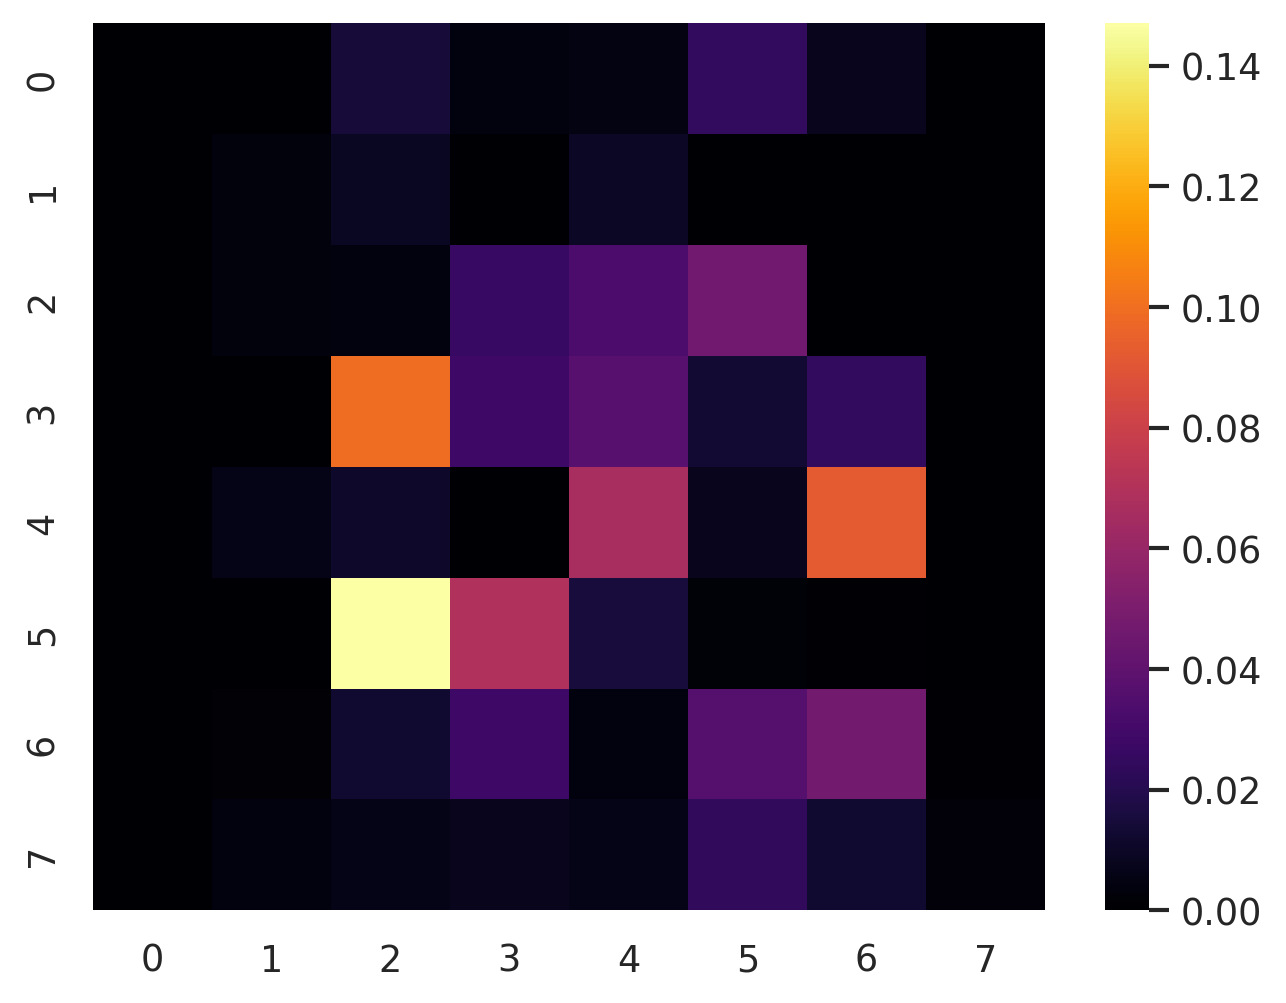

In [ ]:
# TEST_CELL

# Ejercicio 1. Cargar los datos de entrenamiento y prueba del dataset digits.
X_digits_train, X_digits_test, y_digits_train, y_digits_test = load_digits_train_test(0.3)
assert np.all([isinstance(p, np.ndarray)
          for p in (X_digits_train, X_digits_test, y_digits_train, y_digits_test)]), "Revise el ejercicio 1.1"


# Ejercicio 2. Entrenar la exploración de hiperparámetros del modelo de árbol de decisión.
param_grid = {
    "max_depth": range(5, 60, 5),     # Profundidad máxima del árbol de decisión.
    "criterion": ["gini", "entropy"], # Criterio de partición del árbol.
  }
gsearch = tree_grid_search(X_digits_train, y_digits_train, param_grid, k=5)
assert isinstance(gsearch, sklearn.model_selection._search.GridSearchCV), "Revise el ejercicio 1.2"


importances = pixel_importances(gsearch)
if isinstance(importances,np.ndarray):
  if importances.shape == (8, 8):
    plt.figure(dpi = 120)
    sns.heatmap(importances, cmap = 'inferno');
  else:
    print("El arreglo tiene las dimensiones incorrectas.")
    print(f"Tamaño esperado: (8, 8); Tamaño obtenido: {importances.shape}")
else: print("El arreglo retornado no es válido.")

**Salida esperada**

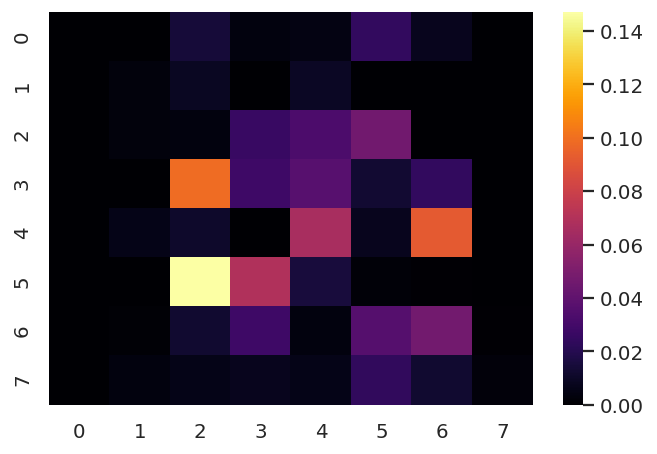

> **Pregunta**:
- ¿Tienen sentido los pixeles con mayor importancia? ¿Qué hay de aquellos con $0$ importancia?

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Pista 1</b></font>
</summary>

* Obtenga las importancias de cada pixel con el atributo **`feature_importances_`** del mejor estimador del objeto **`GridSearchCV`**.


<details>    
<summary>
    <font size="3" color="darkgreen"><b>Pista 2</b></font>
</summary>


* Utilice la función **`reshape`** de _Numpy_ para cambiar el tamaño del arreglo al tamaño requerido de $(8, 8)$.


## **Referencias**
---
- [mlcourse -
Topic 3. Classification, Decision Trees and k Nearest Neighbors
](https://mlcourse.ai/articles/topic3-dt-knn/)
